# Исследовательский анализ данных

## Работа с несколькими источниками данных

1. <a href="#1">Введение</a>
2. <a href="#2">Срез по данным из внешнего словаря</a>
3. <a href="#3">Срез по данным из внешнего словаря (продолжение)</a>
4. <a href="#4">Добавляем столбец</a>
5. <a href="#5">Добавляем столбец (продолжение)</a>
6. <a href="#6">Объединяем данные из двух таблиц</a>
7. <a href="#7">Переименование столбцов</a>
8. <a href="#8">Объединение столбцов методами `merge()` и `join()`</a>
9. <a href="#9">Заключение</a>

<a name="1">_</a>
## Введение

Мы всегда работали с одним датафреймом — все наши данные содержались в таблице data. Так бывает не всегда. Часто приходится объединять данные из разных источников.

**Чему вы научитесь:**
- Делать срез по данным из внешнего словаря;
- Создавать новый столбец по данным из другого датафрейма, списка и Series;
- Присваивать столбцы по порядку строк или по совпадению индексов;
- Объединять данные из двух таблиц;
- Применять методы `join()` и `merge()` для слияния столбцов.

**Вам предстоит:**
- Избавиться от АЗС с долей «аномально быстрых» заездов больше 50%;
- Очистить данные от заправок дольше 1000 секунд;
- Рассчитать медианное время заправки по очищенным данным.


**Постановка задачи:**

Избавьтесь от сверхбыстрых и аномально медленных заправок в наборе данных. Составьте рейтинг АЗС по времени заправки.

<a name="2">_</a>
## Срез по данным из внешнего словаря

В прошлой теме вы обнаружили заправки короче 60 секунд и узнали, как они распределены по АЗС. Выяснили, что на некоторых «плохих» АЗС сверхбыстрых заездов очень много. Оставив станции с такими заездами в наборе данных, рискуем некорректно оценить продолжительность заправки. Лучше избавиться от них.

Очистим таблицу data от АЗС с аномально быстрыми заправками.

Выглядели данные так:

          too_fast
id                
00ca1b70  0.250000
011f7462  0.637489
015eaddd  0.726190
0178ce70  0.211538
018a83ef  0.510269


array([[<AxesSubplot:title={'center':'too_fast'}>]], dtype=object)

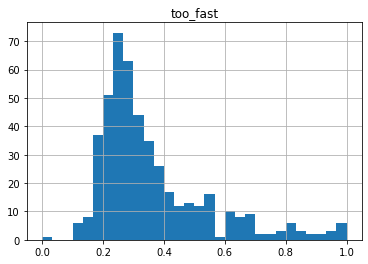

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# обращайте внимание на адрес csv файла и тип разделителя!
data = pd.read_csv('..//datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index="id", values="too_fast")

print(too_fast_stat.head())
too_fast_stat.hist(bins=30)

Нужно выбрать из data только те АЗС, где доля «сверхбыстрых» заправок меньше половины, или 0,5. Назовём такие АЗС «хорошими».
Раньше, чтобы получить срез, вы применяли `query()`. Сейчас случай особенный: в самой таблице data нет информации о том, «хорошая» АЗС или нет. Добыть эти данные можно только из переменной `too_fast_stat`.

Как в `query()` обратиться ко внешней переменной? Например, сравнить значение столбца `'a'` с внешней переменной `variable = 3`
- df.query('a > "variable"')
- df.query('a > #variable#')
- df.query('a > value(variable)')
- df.query('a > @variable')

(4)

Как в query() проверить условие, что значение столбца 'a' равно одному из элементов списка (1, 7, 9, 10, 14)?
- df.query('a == (1, 7, 9, 10, 14)')
- df.query('a = (1, 7, 9, 10, 14)')
- df.query('a in (1, 7, 9, 10, 14)')
- df.query('a is in (1, 7, 9, 10, 14)')

(3)

<a name="3">_</a>
## Срез по данным из внешнего словаря (продолжение)

Вы вспомнили, как в `query()` обратиться ко внешней переменной и проверить, входит ли значение столбца `'a'` в список.
Эти приёмы объединяют, когда во внешней переменной сохранён список. Чтобы узнать, встречается ли значение столбца 'a' в списке `our_list = [1, 2, 3]`, пишут запрос: `'a in @our_list'`.

In [3]:
our_list = [1, 2, 3]
df = pd.DataFrame(
    {
        'a': [0, 1, 10, 11, 12],
        'b': [5, 4, 3, 2, 1],
        'c': ['X', 'Y', 'Y', 'Y', 'Z'],
    }
)
print(
    df.query('a in @our_list')
)  # строим срез, в котором значения столбца 'a' равны элементам списка our_list

   a  b  c
1  1  4  Y


In [4]:
df.query('a in @our_list')

,a,b,c
1,1,4,Y


Пока всё работает привычно. Однако в переменной сохраняют не только числа, строки или списки, но и более сложные структуры: словари, Series, датафреймы. Узнаем, как работает условие для построения среза с ними.

Что если во внешней переменной хранят не список, а словарь? Напомним, что словарь — это структура данных, состоящая из ключа и значения. Пусть в переменной `our_dict` пары ключ-значение: `our_dict = {0: 10, 1: 11, 2: 12}`. Тогда запрос `'a in @our_dict'` будет проверять вхождение значений столбца `'a'` в **ключи** словаря: `0, 1, 2`.


In [5]:
our_dict = {0: 10, 1: 11, 2: 12}
df = pd.DataFrame(
    {
        'a': [0, 1, 10, 11, 12],
        'b': [5, 4, 3, 2, 1],
        'c': ['X', 'Y', 'Y', 'Y', 'Z'],
    }
)

print(
    df.query('a in @our_dict')
)  # строим срез, в котором значения столбца 'a' равны ключам словаря

   a  b  c
0  0  5  X
1  1  4  Y


In [6]:
df.query('a in @our_dict')

,a,b,c
0,0,5,X
1,1,4,Y


Когда в переменной сохранён объект `Series`, конструкция `a in @our_series` проверит вхождение в список **значений**, а не индексов:

In [7]:
our_series = pd.Series([10, 11, 12])
df = pd.DataFrame(
    {
        'a': [0, 1, 10, 11, 12],
        'b': [5, 4, 3, 2, 1],
        'c': ['X', 'Y', 'Y', 'Y', 'Z'],
    }
)
print(
    df.query('a in @our_series')
)  # строим срез, в котором значения столбца 'a' равны значениям Series, но не их индексам

    a  b  c
2  10  3  Y
3  11  2  Y
4  12  1  Z


Если нужно проверить вхождение в **индекс**, это указывают явно, дописывая `index` через точку: `a in @our_series.index`:

In [8]:
our_series = pd.Series([10, 11, 12])
df = pd.DataFrame(
    {
        'a': [0, 1, 10, 11, 12],
        'b': [5, 4, 3, 2, 1],
        'c': ['X', 'Y', 'Y', 'Y', 'Z'],
    }
)
print(
    df.query('a in @our_series.index')
)  # строим срез, в котором значения столбца 'a' равны индексам Series, т.е. 0, 1 или 2

   a  b  c
0  0  5  X
1  1  4  Y


Когда имеют дело с объектом `DataFrame`, вхождение в индекс проверяют так же, как в `Series` — приписав `index` через точку к имени датафрейма:

In [9]:
df = pd.DataFrame(
    {
        'a': [0, 1, 10, 11, 12],
        'b': [5, 4, 3, 2, 1],
        'c': ['X', 'Y', 'Y', 'Y', 'Z'],
    }
)
our_df = pd.DataFrame(
    {
        'a1': [2, 4, 6],
        'b1': [3, 2, 2],
        'c1': ['A', 'B', 'C'],
    }
)
print(
    df.query('a in @our_df.index')
)  # строим срез, в котором значения столбца 'a' равны индексам датафрейма our_df, т.е. 0, 1 или 2

   a  b  c
0  0  5  X
1  1  4  Y


Для проверки вхождения в какой-либо **столбец**, передают его имя. 

Построим срез из значений столбца `'b'` первого датафрейма, равных элементам столбца `'b1'` второго датафрейма:

In [10]:
df = pd.DataFrame(
    {
        'a': [0, 1, 10, 11, 12],
        'b': [5, 4, 3, 2, 1],
        'c': ['X', 'Y', 'Y', 'Y', 'Z'],
    }
)
our_df = pd.DataFrame(
    {
        'a1': [2, 4, 6],
        'b1': [3, 2, 2],
        'c1': ['A', 'B', 'C'],
    }
)
print(
    df.query('b in @our_df.b1')
)  # строим срез, в котором значения столбца 'b' равны значениям столбца b1 датафрейма our_df

    a  b  c
2  10  3  Y
3  11  2  Y


У вас есть всё, чтобы получить правильный срез. Объединим ваши знания в верную последовательность шагов:
- Сделать срез из `too_fast_stat`, где останутся только «хорошие» АЗС (те, на которых доля сверхкоротких заправок меньше 50%);
- Получить срез из `data` с `id` «хороших» АЗС.

### Задача 1/4
Выберите из таблицы data данные только по АЗС с долей «аномально быстрых» заездов меньше 50%. Сравните число «хороших» АЗС с количеством всех АЗС. Решите задачу в несколько шагов:
1. Выберите `id` АЗС, чья доля «аномально быстрых» заездов меньше 50%. Сохраните их `id` в переменной `good_ids`. Получите `id` «хороших» АЗС, применив `query()` к столбцу `too_fast_stat`. Чтобы вспомнить название нужного вам столбца, выполните промежуточное действие — напечатайте таблицу `too_fast_stat`.
2. Отфильтруйте `data` по вхождению в `good_ids.index`. Результат сохраните в `good_data`.
3. Распечатайте число строк в `data`, а затем и число строк в `good_data`.

>В переменной `good_ids` сохраните срез данных из таблицы `too_fast_stat`. Условие среза: доля аномально быстрых заправок меньше 0.5.

>В переменной `good_data` сохраните срез данных из таблицы `data`. В срез должны войти те `id` из `data`, которые встречаются в индексах таблицы `good_ids`. В срезе обратитесь ко внешней переменной `@good_ids`.

>Найдите количество строк функцией `len()`.

In [11]:
import pandas as pd

data = pd.read_csv('../datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

# вспоминаем таблицу too_fast_stat
too_fast_stat = data.pivot_table(index='id', values='too_fast')

# переменная good_ids со срезом данных из таблицы too_fast_stat, условие < 0.5
good_ids = too_fast_stat.query('too_fast < 0.5')

# переменная good_data со срезом данных из таблицы data, id по внешней переменной @
good_data = data.query('id in @good_ids.index')

# число строк в таблицах
print(len(data))
print(len(good_data))

317104
229095


Из 317104 строк осталось 229095. Будем держать в уме, что примерно треть заездов (почти 28 %) на этом этапе мы потеряли. 
Оставшегося вполне хватает, чтобы рассчитать среднее время заправки.

### Задача 2/4
У нас теперь остались только «хорошие» АЗС. Надо избавить их статистику от аномальных заездов. И то, что получится, будем считать пригодными для принятия решения данными.

Мы условились, что **нормальная заправка должна длиться не меньше 60, но не больше 1000 секунд**. Оставьте в `good_data` только данные с нормальной продолжительностью заправки. Результат сохраните в той же переменной. Напечатайте число строк в обновлённой `good_data`.
>Напечатайте `good_data`, чтобы вспомнить название столбца со временем заезда на АЗС.
Составьте условие, что значение столбца больше либо равно 60 и меньше, либо равно 1000 одновременно. Передайте получившееся условие в `query()`. Результат присвойте `good_data`.

In [12]:
good_data
# 229095 строк
# нам нужен столбец 'time_spent'

,date_time,id,time_spent,name,local_time,date_hour,too_fast,too_slow
0,20180406T165358,76144fb2,98.0,Василек,2018-04-06 19:53:58,2018-04-06 20:00:00,False,False
1,20180404T173913,76144fb2,15.0,Василек,2018-04-04 20:39:13,2018-04-04 21:00:00,True,False
2,20180403T172824,76144fb2,220.0,Василек,2018-04-03 20:28:24,2018-04-03 20:00:00,False,False
3,20180407T070441,76144fb2,19.0,Василек,2018-04-07 10:04:41,2018-04-07 10:00:00,True,False
4,20180404T132049,76144fb2,14.0,Василек,2018-04-04 16:20:49,2018-04-04 16:00:00,True,False
...,...,...,...,...,...,...,...,...
317099,20180408T053133,9cdb5039,11.0,Гейхера,2018-04-08 08:31:33,2018-04-08 09:00:00,True,False
317100,20180403T021353,9cdb5039,181.0,Гейхера,2018-04-03 05:13:53,2018-04-03 05:00:00,False,False
317101,20180408T062636,9cdb5039,252.0,Гейхера,2018-04-08 09:26:36,2018-04-08 09:00:00,False,False
317102,20180405T232425,9cdb5039,29.0,Гейхера,2018-04-06 02:24:25,2018-04-06 02:00:00,True,False


In [13]:
# обновим с учетом среза по условию
good_data = good_data.query('60 <= time_spent <= 1000')
#print(good_data)
# в обновленной таблице 154601 строка
print(len(good_data))

154601


Этим данным можно доверять: здесь только "хорошие" АЗС (без пальмового масла, консервантов, ГМО и аномальных заправок).

### Задача 3/4

Вы столько всего выкинули! А что-нибудь от этого поменялось? Уточните, **какой стала типичная продолжительность заправки** на АЗС.

Примените `pivot_table` к датафрейму `good_data` и составьте рейтинг, где каждой АЗС (`id`) соответствует медианное время заправки.

Сводную таблицу сохраните в `good_stations_stat`. Постройте гистограмму `good_stations_stat` c 50 корзинами.

>Чтобы припомнить названия столбцов с а) идентификаторами АЗС и б) временем на них, распечатайте good_data.
Результат посчитайте методом `pivot_table`. Передайте `id` и время заправки в параметрах `index` и `values`. В `aggfunc` укажите медиану. Полученный результат сохраните в переменной `good_stations_stat`.

>Постройте гистограмму методом `hist()`, передайте нужное число корзин параметром `bins`.

In [14]:
# вспоминаем названия столбцов
#good_data

In [15]:
# сводная таблица по good_data, где каждому id соответствует медианное время заправки time_spent
good_stations_stat = good_data.pivot_table(index="id", values="time_spent", aggfunc="median")

array([[<AxesSubplot:title={'center':'time_spent'}>]], dtype=object)

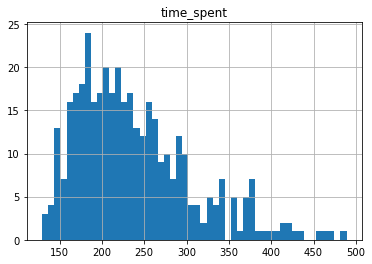

In [16]:
good_stations_stat.hist(bins=50)

Большая масса АЗС сместилась в диапазон времени заправки 150-300 секунд. Выглядит правдоподобно. Никофе, ни туалета, залились - и в путь.

### Задача 4/4
Всё готово для составления рейтинга сетей АЗС.
Примените `pivot_table` к `good_data` и постройте рейтинг, где каждому названию сети АЗС соответствует медианное время заправки. Сводную таблицу сохраните в `good_stat`.

Выведите `good_stat`, отсортировав по возрастанию времени.
>Задачу решайте, как предыдущую. Только группируйте не по id, а по имени сети АЗС. Выведите на экран good_data, чтобы вспомнить имя столбца с названием сетей АЗС.

>Значения по возрастанию времени получите методом `sort_values('time_spent')`.

In [17]:
# прекод
import pandas as pd

data = pd.read_csv("../datasets/visits.csv", sep="\t")
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index="id", values="too_fast")
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)


# в сводной таблице good_stat отсортируем названия станций по медианному времени заправки
good_stat = good_data.pivot_table(index="name", values="time_spent", aggfunc="median")
# значения по возрастанию времени
print(good_stat.sort_values(by = 'time_spent', ascending=True))

             time_spent
name                   
Белоцветник       154.0
Бальзамин         158.0
Незабудка         161.0
Колокольчик       161.0
Обриета           167.0
Функия            171.5
Гацания           178.5
Аммобиум          180.5
Пион              180.5
Бархатцы          181.5
Мальва            182.0
Ирис              185.0
Арктотис          185.0
Люпин             186.0
Амарант           187.5
Хризантема        188.0
Тюльпан           190.0
Ромашка           191.0
Бегония           195.0
Вербена           199.0
Гейхера           204.0
Вероника          212.0
Левкой            212.5
Подснежник        218.5
Доротеантус       220.0
Диморфотека       224.0
Немезия           226.0
Гвоздика          229.0
Малопа            229.0
Календула         254.0
Крокус            257.5
Василек           264.0
Космос            267.0
Георгина          279.0
Лаватера          282.0
Агератум          309.0
Роза              315.0
Петуния           319.5
Гелихризум        342.0
Астильба        

Вот он, наш долгожданный рейтинг!

<a name="4">_</a>
## Добавляем столбец

В прошлом уроке вы смело выбросили неправдоподобные наблюдения.

Сравним с тем временем, что было раньше. Построим 2 гистограммы: по исходным данным raw (англ. «необработанный, сырой») и новым `filtered` (англ. «отфильтрованный»).

<AxesSubplot:ylabel='Frequency'>

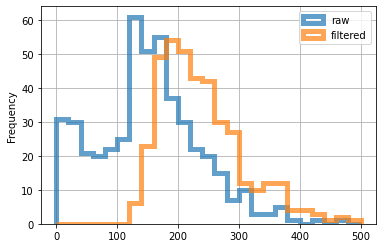

In [18]:
median_station_stat = data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)
good_station_stat = good_data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)

ax = median_station_stat.plot(
    kind='hist',
    y='time_spent',
    histtype='step',
    range=(0, 500),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='raw',
)
good_station_stat.plot(
    kind='hist',
    y='time_spent',
    histtype='step',
    range=(0, 500),
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='filtered',
    ax=ax,
    grid=True,
    legend=True,
)

Обратите внимание, что мы вызвали не метод `hist()`, а `plot()` с параметром `kind` (англ. «вид»), которому установили значение `kind='hist'`. Та же гистограмма, только её построил не `hist()`, а `plot()`. Он умеет задействовать не поддерживаемые методом `hist()` параметры. Взгляните на полученные гистограммы

Выглядят непривычно. Всё из-за ряда новых параметров:

- **histtype** (от англ. the type of histogram, «тип гистограммы»). В параметре указывают тип гистограммы, по умолчанию — это столбчатая (закрашенная). Значение 'step' (англ. «шаг») чертит только линию.
- **linewidth** (от англ. width of line, «толщина линии»). Задаёт толщину линии графика в пикселях.
alpha (от термина «альфа-канал»). Назначает густоту закраски линии. 1 — это 100% закраска; 0 — прозрачная линия. С параметром 0.7 линии чуть прозрачны, так виднее их пересечения.
- **label** (англ. «ярлык, этикетка»). Название линии.
- **ax** (от англ. axis — «ось»). Метод plot() возвращает оси, на которых был построен график. Чтобы обе гистограммы расположились на одном графике, сохраним оси первого графика в переменной ax, а затем передадим её значение параметру ax второго plot(). Так, сохранив оси одной гистограммы и построив вторую на осях первой, мы объединили два графика.
- **legend** (англ. «легенда»). Выводит легенду — список условных обозначений на графике. На нашем графике вы можете найти её в верхнем правом углу.

Оставшиеся параметры `y`, `range`, `bins`, `grid` хорошо вам известны и не нуждаются в дополнительном представлении.

Разобравшись, как получились две гистограммы, сравните их. Видно огромное различие на малых временах. В «сырых» данных есть большая группа АЗС с продолжительностью заправки менее 50 секунд. В отфильтрованных ничего подобного — мы сами отбросили АЗС с заездами короче 60 секунд. На самой «быстрой» АЗС в отфильтрованных данных заправляются дольше 100 секунд, а типичная продолжительность заправки около 200. Такое распределение больше похоже на правду, чем исходная гистограмма. Отсеяв всё лишнее и нереалистичное, вы проделали хорошую работу.

На график какого из известных вам распределений похожа отфильтрованная гистограмма?
- нормальное распределение
- распределение Пуассона
- распределение Гаусса
- биномиальное распределение
(2)

<a name="5">_</a>
## Добавляем столбец (продолжение)

Диаграмма реалистична как раз потому, что похожа на распределение Пуассона, которое описывает время визитов, стояния в очередях и других подобных событий. Вы и заподозрили в данных неладное потому, что гистограмма совсем не напоминала пуассоновскую.

Общее усовершенствование гистограммы очевидно. Однако как изменились значения для каждой отдельной АЗС и для сетей? У нас есть отдельные `stat` и `good_stat`. Чтобы увидеть значения бок о бок, нужно собрать их в один датафрейм.

**Научимся добавлять столбец из одного датафрейма к другому** на простом примере.


In [19]:
df1 = pd.DataFrame({'a': [1, 2, 3, 3, 3], 'b': ['Q', 'R', 'S', 'T', 'U']})
df2 = pd.DataFrame(
    {
        'c': [3, 4, 5, 6, 7],
        'd': ['V', 'W', 'X', 'Y', 'Z'],
        'e': [3, 3, 3, 3, 3],
    }
)
print(df1)
print()
print(df2)

   a  b
0  1  Q
1  2  R
2  3  S
3  3  T
4  3  U

   c  d  e
0  3  V  3
1  4  W  3
2  5  X  3
3  6  Y  3
4  7  Z  3


Чтобы добавить в `df1` столбец из `df2`, создадим новый столбец в `df1` и присвоим ему значения столбца `df2`.

In [20]:
df1 = pd.DataFrame({'a': [1, 2, 3, 3, 3], 'b': ['Q', 'R', 'S', 'T', 'U']})
df2 = pd.DataFrame(
    {
        'c': [3, 4, 5, 6, 7],
        'd': ['V', 'W', 'X', 'Y', 'Z'],
        'e': [3, 3, 3, 3, 3],
    }
)
print(df1)
print()
print(df2)
df1['new'] = df2['d']
print()
print(df1)

   a  b
0  1  Q
1  2  R
2  3  S
3  3  T
4  3  U

   c  d  e
0  3  V  3
1  4  W  3
2  5  X  3
3  6  Y  3
4  7  Z  3

   a  b new
0  1  Q   V
1  2  R   W
2  3  S   X
3  3  T   Y
4  3  U   Z


Если бы столбец `new` уже был в `df1`, то все его элементы были бы удалены, а вместо них записаны новые:

In [21]:
df1 = pd.DataFrame(
    {'a': [1, 2, 3, 3, 3], 'new': ['Q', 'R', 'S', 'T', 'U']}
)  # столбец new уже есть
df2 = pd.DataFrame(
    {
        'c': [3, 4, 5, 6, 7],
        'd': ['V', 'W', 'X', 'Y', 'Z'],
        'e': [3, 3, 3, 3, 3],
    }
)
print(df1)
print()
print(df2)
df1['new'] = df2['d']
print()
print(df1)

   a new
0  1   Q
1  2   R
2  3   S
3  3   T
4  3   U

   c  d  e
0  3  V  3
1  4  W  3
2  5  X  3
3  6  Y  3
4  7  Z  3

   a new
0  1   V
1  2   W
2  3   X
3  3   Y
4  3   Z


Кажется просто: Pandas копирует столбец из `df2` и вставляет его в `df1`.

Однако всё сложнее. Для каждой строки первого датафрейма Pandas ищет «пару» — строку с таким же индексом во втором датафрейме. Находит и берёт значение из этой строки. В нашем случае индексы в `df1` и `df2` совпадали, и всё казалось простым копированием строк по порядку.

Поменяем индексы в `df2`. Вызовем метод `set_index()`, передадим ему название столбца, который заменит собой индекс: при этом пропадёт и сам столбец, и старый индекс. Метод `set_index()` **не меняет исходный датафрейм, а возвращает обновлённый**. Если же оригинальную таблицу нужно заменить, добавляют параметр `inplace=True`.

Заменим индексы во втором датафрейме на значения столбца `c`. После чего присвоим столбцу `new` в первом датафрейме значения столбца `d` в `df2`:

In [22]:
df1 = pd.DataFrame({'a': [1, 2, 3, 3, 3], 'b': ['Q', 'R', 'S', 'T', 'U']})
df2 = pd.DataFrame(
    {
        'c': [3, 4, 5, 6, 7],
        'd': ['V', 'W', 'X', 'Y', 'Z'],
        'e': [3, 3, 3, 3, 3],
    }
)
df2.set_index('c', inplace=True)
print(df1)
print()
print(df2)
df1['new'] = df2['d']
print()
print(df1)

   a  b
0  1  Q
1  2  R
2  3  S
3  3  T
4  3  U

   d  e
c      
3  V  3
4  W  3
5  X  3
6  Y  3
7  Z  3

   a  b  new
0  1  Q  NaN
1  2  R  NaN
2  3  S  NaN
3  3  T    V
4  3  U    W


Индексы в df1 и df2 уже не одинаковы. Присвоение происходит лишь по совпадающим индексам. В df2 нет индексов 0, 1, 2 — в этих строках финального датафрейма оказались NaN. А в строках с индексами 3 и 4 записаны значения, которые в df2['d'] были в строках с индексами 3 и 4.

Если в df1 будут повторяющиеся индексы, то значение из df2['d'] скопируется несколько раз. Заменим индексы в df1 на значения столбца a:

In [23]:
df1.set_index('a', inplace=True)
print(df1)
print()
print(df2)
print()
df1['new'] = df2['d']
print(df1)

   b  new
a        
1  Q  NaN
2  R  NaN
3  S  NaN
3  T    V
3  U    W

   d  e
c      
3  V  3
4  W  3
5  X  3
6  Y  3
7  Z  3

   b  new
a        
1  Q  NaN
2  R  NaN
3  S    V
3  T    V
3  U    V


В столбце `new` в строках с совпадающим индексом 3 одинаковые значения `'Y'`.
Число строк в `df2` не обязательно должно совпадать с числом строк `df1`. Если в `df2` не хватит значений, то будет `None`. А будут лишние — просто не попадут в обновлённый датафрейм.

А вот повторяющиеся значения в индексе `df2` приведут к **ошибке**. Pandas не поймёт, какое из значений следует подставить в `df1`.


In [24]:
df1 = pd.DataFrame({'a': [1, 2, 3, 3, 3], 'b': ['Q', 'R', 'S', 'T', 'U']})
df2 = pd.DataFrame(
    {
        'c': [3, 4, 5, 6, 7],
        'd': ['V', 'W', 'X', 'Y', 'Z'],
        'e': [3, 3, 3, 3, 3],
    }
)
df2.set_index('e', inplace=True)
print(df1)
print()
print(df2)
print()
df1['new'] = df2['d']

   a  b
0  1  Q
1  2  R
2  3  S
3  3  T
4  3  U

   c  d
e      
3  3  V
3  4  W
3  5  X
3  6  Y
3  7  Z



ValueError: cannot reindex from a duplicate axis

В примерах мы присваивали один столбец из датафрейма: в `df1['new']` сохраняли значения из `df2['d']`.

Отдельный столбец можно создать и без датафрейма, в `Series` — это будет набор значений с индексами. При попытке присвоить объект с индексами, Pandas подберёт соответствующие индексам строки.


In [25]:
df1 = pd.DataFrame({'a': [1, 2, 3, 3, 3], 'b': ['Q', 'R', 'S', 'T', 'U']})
print(df1)
df1.set_index('a', inplace=True)
series = pd.Series([1, 2, 3, 4, 5])
print()
print(series)
df1['new'] = series
print()
print(df1)

   a  b
0  1  Q
1  2  R
2  3  S
3  3  T
4  3  U

0    1
1    2
2    3
3    4
4    5
dtype: int64

   b  new
a        
1  Q    2
2  R    3
3  S    4
3  T    4
3  U    4


Если передавать столбцу список значений, сохранённых не как `Series`, а например, как `list`, присвоение будет идти по порядку строк.

In [26]:
df1 = pd.DataFrame({'a': [1, 2, 3, 3, 3], 'b': ['Q', 'R', 'S', 'T', 'U']})
print(df1)
list_values = [1, 2, 3, 4, 5]
df1['new'] = list_values
print()
print(df1)

   a  b
0  1  Q
1  2  R
2  3  S
3  3  T
4  3  U

   a  b  new
0  1  Q    1
1  2  R    2
2  3  S    3
3  3  T    4
4  3  U    5


Индексы `df1` проигнорированы, значения в `new` записаны по порядку.

Важно знать, как ведут себя данные при присвоении `list` и `Series`, чтобы не повстречать неожиданные результаты.

### Задача
Добавьте в `stat` столбец `good_time_spent` со значениями времени заправки в сети АЗС из `good_stat`. Распечатайте все значения `stat`.
>Вспомните, в каком столбце хранится типичная продолжительность заправки в сетях: распечатайте `stat`. Присвойте столбцу `stat` с именем `good_time_spent` данные из столбца `good_stat` с типичным временем заправки.

In [27]:
import pandas as pd

data = pd.read_csv('../datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index='id', values='too_fast')
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(
    index='name', values='time_spent', aggfunc='median'
)

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(index='name', values='time_spent', aggfunc='median')
stat['good_time_spent'] = good_stat['time_spent']
print(stat)

             time_spent  good_time_spent
name                                    
Агератум     337.802721            309.0
Амарант      132.760012            187.5
Аммобиум     256.708042            180.5
Арктотис      73.879984            185.0
Астильба     376.143149            423.0
Бальзамин    134.508411            158.0
Бархатцы     145.300328            181.5
Бегония      163.200647            195.0
Белоцветник  100.818966            154.0
Василек      268.849897            264.0
Вербена      190.016594            199.0
Вероника     220.019402            212.0
Гацания      160.685185            178.5
Гвоздика     294.317308            229.0
Гейхера      167.445947            204.0
Гелихризум   290.138643            342.0
Георгина     166.615555            279.0
Годеция      113.958333              NaN
Диморфотека  406.161017            224.0
Доротеантус  263.568916            220.0
Ирис         179.931159            185.0
Календула    207.357323            254.0
Колокольчик  119

После фильтрации исходных данных и расчета медианы вместо среднего. Типичная продолжительность заправки в сетях изменилась. Неодинаково в разных сетях.

В сети "Агератум» упала с 338 до 309, а в сети"Амарант" выросла с 133 до 188. Есть и значительные изменения. "Арктотис": с 74 до 185 - рост в 2,5 раза! "Функия": с 302 до 172 - падение почти в два раза. Фильтрация сильно поменяла рейтинг.


<a name="6">_</a>
## Объединяем данные из двух таблиц

Вы получили итоговый рейтинг. Полагаем, он лучше, чем исходный. Но ему пока недостаёт точности.

Типичную продолжительность заправки в сети мы считали как медианную длительность заправок на всех АЗС сети. Да, если все АЗС в сети похожи, то как ни усредняй, получишь примерно те же значения. А что, если нет? Что, если данные на разных АЗС различаются на порядок?

В таблице `gas_check_ins.csv` данные о 10 АЗС вымышленной сети. Взглянем на первые 10 строк:

In [28]:
gas_check_ins = pd.read_csv('../datasets/gas_check_ins.txt', sep=';')
gas_check_ins.head(10)

,id,Gas station,Time
0,4826,GasOne,60
1,1186,GasSeven,180
2,2643,GasOne,60
3,2891,GasOne,60
4,4662,GasOne,60
5,3499,GasOne,60
6,661,GasFour,180
7,3850,GasOne,60
8,1142,GasOne,60
9,852,GasOne,60


ID, название АЗС и продолжительность заправки в секундах. Пока всё понятно. Узнаем, сколько зафиксировано заездов на каждую заправку:

На GasOne целых 10 000 заездов, на остальных — чуть больше 100. Существенная разница, будем держать её в уме.

Найдём типичную продолжительность заправки: рассчитаем среднее арифметическое и медиану.

На заправке GasOne побывало 10000 автомобилей и все заправлялись одну минуту. Как на Формуле 1! На остальных АЗС на заправку требовалось втрое больше времени.

По медиане видно, что GasOne полностью подавила данные о других станциях сети. 10 000 наблюдений на выдающейся GasOne повлияли и на среднее арифметическое.

Усредним данные продолжительности заправки по АЗС:

In [29]:
gas_stations = pd.DataFrame(
    {
        'Name': [
            'GasOne',
            'GasTwo',
            'GasThree',
            'GasFour',
            'GasFive',
            'GasSix',
            'GasSeven',
            'GasEight',
            'GasNine',
            'GasTen',
        ],
        'Num_check_in': [10000, 100, 110, 105, 113, 102, 125, 116, 109, 120],
        'Time': [
            60,
            180,
            180,
            180,
            180,
            180,
            180,
            180,
            180,
            180,
        ],
    }
)
print(gas_stations)

       Name  Num_check_in  Time
0    GasOne         10000    60
1    GasTwo           100   180
2  GasThree           110   180
3   GasFour           105   180
4   GasFive           113   180
5    GasSix           102   180
6  GasSeven           125   180
7  GasEight           116   180
8   GasNine           109   180
9    GasTen           120   180


Посчитаем среднее и медиану:

In [30]:
print('Среднее арифметическое время заправки:', gas_stations['Time'].mean())
print('Медиана времени заправки:', gas_stations['Time'].median())

Среднее арифметическое время заправки: 168.0
Медиана времени заправки: 180.0


Вот такая разница при смене метода усреднения: сразу считать среднее по всем заездам или сначала по АЗС, а потом уже среднее из средних. Во втором случае среднее подскочило с 71 до 168 секунд, а медиана — с 60 до 180. Это утрированный пример, но в реальных задачах выбор метода усреднения может радикально поменять ваши выводы. Поэтому аналитику важно понимать как природу изучаемых данных, так и постановку задачи.

Так, взяв среднее арифметическое по всем заездам на АЗС, отвечаем на вопрос, сколько средний человек проводит на конкретной станции. А если нужно знать, сколько времени водители проводят на средней АЗС сети — это уже другой вопрос. Чувствуете разницу?

Нам нужен второй вариант. К тому же такой расчёт более устойчив к проблемам на отдельных АЗС. Если время по какой-то одной АЗС привели неверно, то медиана позволит практически игнорировать этот выброс.

Нам нужны параметры АЗС, типичной для сети, среднестатистической, а не выдающейся: очень крупной, быстрой или медленной. Сделаем более устойчивую оценку.

Сперва найдём медианное время заезда, а затем уже объединим до значений в сетях.

Медиану времени заезда на каждую АЗС вы уже считали:

In [31]:
print(good_stations_stat.head())

          time_spent
id                  
00ca1b70       166.0
0178ce70       234.5
01abf4e9       181.5
030a9067       135.5
03740f2d       289.0


Непонятно, какой сети принадлежат id. Это решаемо.
Вспомним, как выглядели исходные данные в data:

In [32]:
print(data.head())

         date_time        id  time_spent     name          local_time  \
0  20180406T165358  76144fb2        98.0  Василек 2018-04-06 19:53:58   
1  20180404T173913  76144fb2        15.0  Василек 2018-04-04 20:39:13   
2  20180403T172824  76144fb2       220.0  Василек 2018-04-03 20:28:24   
3  20180407T070441  76144fb2        19.0  Василек 2018-04-07 10:04:41   
4  20180404T132049  76144fb2        14.0  Василек 2018-04-04 16:20:49   

            date_hour  too_fast  too_slow  
0 2018-04-06 20:00:00     False     False  
1 2018-04-04 21:00:00      True     False  
2 2018-04-03 20:00:00     False     False  
3 2018-04-07 10:00:00      True     False  
4 2018-04-04 16:00:00      True     False  


В каждой строке есть идентификатор АЗС id и название сети name. Нам нужны пары: АЗС — название сети. И хорошо бы знать число заездов на каждую АЗС.

`pivot_table` группирует данные, а что с ними делать, указывает значение параметра `aggfunc`. Например:
- **`'median'`** — медианное значение;
- **`'count'`** — количество значений;
- **`'sum'`** — сумма значений;
- **`'min'`** — минимальное значение;
- **`'max'`** — максимальное значение;
- **`'first'`** — первое значение из группы;
- **`'last'`** — последнее значение из группы.

Что происходит, когда в `aggfunc` передают `'first'` и `'last'`? Возьмём, к примеру таблицу с ингредиентами завтраков:

In [33]:
import pandas as pd

df = pd.DataFrame(
    {
        'завтрак': [
            'омлет',
            'омлет',
            'омлет',
            'бутерброд',
            'бутерброд',
            'бутерброд',
        ],
        'ингредиенты': ['яйца', 'молоко', 'соль', 'хлеб', 'ветчина', 'сыр'],
    }
)
print(df)

     завтрак ингредиенты
0      омлет        яйца
1      омлет      молоко
2      омлет        соль
3  бутерброд        хлеб
4  бутерброд     ветчина
5  бутерброд         сыр


Применим `pivot_table`, где индексом будет завтрак, а значениями — ингредиенты. В `aggfunc` передадим `'first'`:

In [34]:
df.pivot_table(index='завтрак', values='ингредиенты', aggfunc='first')

,ингредиенты
завтрак,
бутерброд,хлеб
омлет,яйца


Для каждого завтрака мы подтянули первую строку с ингредиентами. Догадайтесь, строку с каким ингредиентом мы получим, если передадим `'last'`:


In [35]:
df.pivot_table(index='завтрак', values='ингредиенты', aggfunc='last')

,ингредиенты
завтрак,
бутерброд,сыр
омлет,соль


В одном вызове `pivot_table` можно передать параметру `aggfunc` cписком сразу несколько функций. Например, `aggfunc=['median', 'count']` посчитает и медиану, и число значений — в результирующей таблице они будут в соседних столбцах.

Кроме числа заездов на АЗС, можно добыть и название сети из столбца `name`. Если мы передаём в `pivot_table` параметр `index='id'`, то будут сгруппированы данные с совпадающим `id`. Значит, у всех будет одинаковое имя сети name (ведь одна АЗС приписана строго к одной сети). Нужно выбрать любую из строк, например, первую, передав значение `'first'` параметру `aggfunc`.

### Задача
Примените `pivot_table()` и получите из `good_data` таблицу соответствия: идентификатор АЗС, название сети, число заездов.
Результат сохраните в переменной `id_name`. Выведите первые 5 строк этой таблицы.
>Примените `pivot_table` к таблице `good_data`. В качестве индекса передайте идентификатор АЗС, как значения — названия сетей; `aggfunc` должен принять на вход список из двух функций: взять первое значение, посчитать число значений.

In [36]:
import pandas as pd
# внимание к адресу csv файла
data = pd.read_csv('../datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index="id", values="too_fast")
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(
    index='name', values='time_spent', aggfunc='median'
)
stat['good_time_spent'] = good_stat['time_spent']
# переменная id_name - слияние столбцов из good_data по идентификатору АЗС, названию сети, числу заездов
id_name = good_data.pivot_table(index='id', values='name', aggfunc=['first', 'count'])
print(id_name.head())

                first count
                 name  name
id                         
00ca1b70     Вероника   131
0178ce70      Василек   164
01abf4e9      Гацания    30
030a9067  Колокольчик   228
03740f2d      Василек   157


Двухэтажные названия столбцов - это оригинально

<a name="7">_</a>
## Переименование столбцов

Вы передали список функций в `aggfunc` и получили двухэтажные названия столбцов. Это вовсе не ошибка, а **мультииндекс**. Такое случается, когда в индексе не одно значение, а целый список.

В нашей задаче это усложнение излишне. Зададим обычные названия столбцов. Запишем их в атрибуте `columns` так:

### Задача
Дайте имена колонкам датафрейма `id_name`. Первый столбец назовите 'name', а второй — 'count'.

Напечатайте первые 5 строк `id_name`.
>Присвойте список с названиями столбцов атрибуту `columns` датафрейма `id_name`. Первые пять строк выведите методом `head()`.

In [37]:
import pandas as pd

data = pd.read_csv('../datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index="id", values="too_fast")
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(
    index='name', values='time_spent', aggfunc='median'
)
stat['good_time_spent'] = good_stat['time_spent']

id_name = good_data.pivot_table(
    index='id', values='name', aggfunc=['first', 'count']
    )
# переименуем столбцы и выведем первые пять строк датафрейма id_name
id_name.columns = ['name', 'count']
print(id_name.head())

                 name  count
id                          
00ca1b70     Вероника    131
0178ce70      Василек    164
01abf4e9      Гацания     30
030a9067  Колокольчик    228
03740f2d      Василек    157


Все простое обычно неправильно, а правильное по большей части непросто.
А у вас все правильно, как в японском саду камней.

<a name="8">_</a>
## Объединение столбцов методами `merge()` и `join()`

У вас есть таблица `id_name`: с идентификатором каждой АЗС, названием её сети и числом заездов. Для полного счастья не хватает добавить в `id_name` типичное время заправки из `good_station_stat`. Напомним, какие данные вы там сохранили:

In [38]:
print(good_station_stat.head())

          time_spent
id                  
00ca1b70       166.0
0178ce70       234.5
01abf4e9       181.5
030a9067       135.5
03740f2d       289.0


Объединяя `id_name` и `good_station_stat`, можно по очереди присваивать значения столбца одной таблицы столбцу другой:

In [39]:
good_station_stat['name'] = id_name['name']
good_station_stat['count'] = id_name['count']

Или же вспомнить метод `merge()` и соединить датафреймы им.

Два ученика договорились, что первый спишет с доски половину списка литературы на лето, и уйдёт в столовую есть булочки, а второй тогда оторвётся от игры в танчики и зафиксирует оставшуюся часть. В конце сложат половины списков. Так и дела будут сделаны, и танчики подбиты, и булки съедены.

Посмотрим, что из этого вышло:

In [40]:
first_pupil_df = pd.DataFrame(
    {
        'author': ['Фонвизин', 'Грибоедов', 'Пушкин', 'Гоголь', 'Лермонтов'],
        'literary_work': [
            'Недоросль',
            'Горе от ума',
            'Капитанская дочка',
            'Ревизор',
            'Мцыри',
        ],
    }
)
second_pupil_df = pd.DataFrame(
    {
        'author': ['Пушкин', 'Гоголь', 'Лермонтов', 'Островский', 'Тургенев'],
        'literary_work': [
            'Евгений Онегин',
            'Мёртвые души',
            'Герой нашего времени',
            'Гроза',
            'Отцы и дети',
        ],
    }
)
print(first_pupil_df)
print()
print(second_pupil_df)

      author      literary_work
0   Фонвизин          Недоросль
1  Грибоедов        Горе от ума
2     Пушкин  Капитанская дочка
3     Гоголь            Ревизор
4  Лермонтов              Мцыри

       author         literary_work
0      Пушкин        Евгений Онегин
1      Гоголь          Мёртвые души
2   Лермонтов  Герой нашего времени
3  Островский                 Гроза
4    Тургенев           Отцы и дети


Методом `merge()` объединим строки датафреймов учеников, по совпадающим значениям столбца `'author'`:

In [41]:
first_pupil_df.merge(second_pupil_df, on='author') # название столбца, по которому объединять, передают в параметре on

,author,literary_work_x,literary_work_y
0,Пушкин,Капитанская дочка,Евгений Онегин
1,Гоголь,Ревизор,Мёртвые души
2,Лермонтов,Мцыри,Герой нашего времени


Финальная таблица сложилась из совпадений по авторам записей первого и второго учеников. Такой тип объединения называется **inner** (от англ. «внутренний»). Он собирает данные из внутренней области (которые есть в обоих датафреймах). В `merge()` тип `inner` работает по умолчанию. Ему противоположен тип слияния **outer** (от англ. «внешний»). Он объединяет данные из внешней общей области — такие, которые есть хотя бы в одном из датафреймов. Режим объединения задаётся параметром `how` (от англ. «как, каким образом»).

Объединим фрагменты списка литературы ещё раз, со значением `'outer'` параметра `how`:

In [42]:
first_pupil_df.merge(second_pupil_df, on='author', how='outer')

,author,literary_work_x,literary_work_y
0,Фонвизин,Недоросль,NaN
1,Грибоедов,Горе от ума,NaN
2,Пушкин,Капитанская дочка,Евгений Онегин
3,Гоголь,Ревизор,Мёртвые души
4,Лермонтов,Мцыри,Герой нашего времени
5,Островский,NaN,Гроза
6,Тургенев,NaN,Отцы и дети


Список литературы на лето готов, мы не упустили ни одной записи. Обратите внимание, если данных нет, в ячейках — `NaN`.

Режим объединения `'left'` указывает, что в результат слияния обязательно должны войти все строки из левого датафрейма:

In [43]:
first_pupil_df.merge(second_pupil_df, on='author', how='left')

,author,literary_work_x,literary_work_y
0,Фонвизин,Недоросль,NaN
1,Грибоедов,Горе от ума,NaN
2,Пушкин,Капитанская дочка,Евгений Онегин
3,Гоголь,Ревизор,Мёртвые души
4,Лермонтов,Мцыри,Герой нашего времени


Сохранились записи первого ученика и записи по совпадающим авторам. А вот новых строк от второго ученика не видно. Такой список не укажет, что за лето нужно успеть осилить Островского и Тургенева.

В аналогичном режиме `'right'` сохранятся все совпадающие строки и правый датафрейм.

В таблице-результате работы метода `merge()` к названиям столбцов добавились` _x` и `_y`. Окончания названий столбцов задают в параметре `suffixes` (от англ. suffix — «суффикс, окончание»):

In [44]:
first_pupil_df.merge(second_pupil_df, on='author', how='left', suffixes=('_записал первый', '_записал второй'))

,author,literary_work_записал первый,literary_work_записал второй
0,Фонвизин,Недоросль,NaN
1,Грибоедов,Горе от ума,NaN
2,Пушкин,Капитанская дочка,Евгений Онегин
3,Гоголь,Ревизор,Мёртвые души
4,Лермонтов,Мцыри,Герой нашего времени


Если столбец индекса именованный, его имя также можно передать параметру **on**. Объединять можно и по нескольким столбцам сразу — достаточно передать список параметру `on`.

Метод `join()` похож на `merge()`. Без параметра `on` этот `join()` будет искать совпадения по индексам в первом и втором датафреймах. Если же передать параметру `on` столбец, то `join()` найдёт его в первом датафрейме и начнёт сравнивать с индексом второго. В отличие от `merge()`, по умолчанию в `join()` установлен тип слияния `how='left'`. А параметр `suffixes` разделён на два независимых: **lsuffix** (от англ. left suffix, «левый суффикс») и **rsuffix** (от англ. right suffix, «правый суффикс»). 

Ещё методом `join()` можно объединять больше двух таблиц: их набор передают списком вместо второго датафрейма.

Объединим два датафрейма по столбцу `'a'` методом `join()`. Выведем столбец `'c'`:

In [45]:
df1 = pd.DataFrame({'a': [1, 2, 3, 4], 'b': ['A', 'B', 'C', 'D']})
df2 = pd.DataFrame({'a': [2, 2, 2, 2], 'c': ['E', 'F', 'G', 'H']})
print(df1)
print()
print(df2)
print()
print (df1.join(df2, on='a', rsuffix='_y')['c'])

   a  b
0  1  A
1  2  B
2  3  C
3  4  D

   a  c
0  2  E
1  2  F
2  2  G
3  2  H

0      F
1      G
2      H
3    NaN
Name: c, dtype: object


Каждому значению в столбце `'a'` первого датафрейма метод ищет соответствие в индексах второго датафрейма. И находит. В индексах второго датафрейма есть 1, 2 и 3. На экран выводят соответствующие им значения столбца `'c'`: F, G и H. В индексах второго датафрейма нет 4: `join()` не находит её и возвращает в итоговый столбец `NaN`.

Разобравшись с работой `merge()` и `join()`, примените их к таблицам `id_name` и `good_stations_stat`. Напомним их устройство:

In [46]:
print(id_name.head())
print()
print(good_stations_stat.head())

                 name  count
id                          
00ca1b70     Вероника    131
0178ce70      Василек    164
01abf4e9      Гацания     30
030a9067  Колокольчик    228
03740f2d      Василек    157

          time_spent
id                  
00ca1b70       166.0
0178ce70       234.5
01abf4e9       181.5
030a9067       135.5
03740f2d       289.0


### Задача 1/4
Объедините данные из `id_name` и `good_stations_stat` так, чтобы в итоговом датафрейме были все 3 столбца: `'name'`, `'count'`, `'time_spent'`. Результат сохраните в таблице `station_stat_full`, напечатайте её первые 5 строк.
>Вам нужно объединить два датафрейма по совпадающим индексам. Для этого подходит метод `join()`. Примените `join()` к `id_name`, передавая параметром `good_stations_stat`.

In [47]:
import pandas as pd

data = pd.read_csv('../datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index='id', values='too_fast')
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(
    index='name', values='time_spent', aggfunc='median'
)
stat['good_time_spent'] = good_stat['time_spent']

id_name = good_data.pivot_table(
    index='id', values='name', aggfunc=['first', 'count']
)
id_name.columns = ['name', 'count']
# Объединяеммданные из id_name и good_stations_stat
station_stat_full = id_name.join(good_stations_stat)
print(station_stat_full.head())

                 name  count  time_spent
id                                      
00ca1b70     Вероника    131       166.0
0178ce70      Василек    164       234.5
01abf4e9      Гацания     30       181.5
030a9067  Колокольчик    228       135.5
03740f2d      Василек    157       289.0


### Задача 2/4
Нужно установить минимальную границу по числу заездов, ниже которой данные о среднем времени заправки можно считать ненадёжными (чтобы исключить их влияние на типичную продолжительность).

Постройте гистограмму значений `'count'` из `station_stat_full` с 30 корзинами.

И ещё одну гистограмму по тем же значениям на 30 корзин, но для диапазона от 0 до 300 заездов.

Сравните полученные графики.
>К таблице `station_stat_full` примените метод `hist()`, первым аргументом передайте название столбца. В параметре `bins` укажите 30 корзин. В параметре `range` укажите диапазон.

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

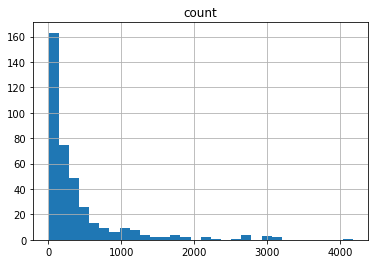

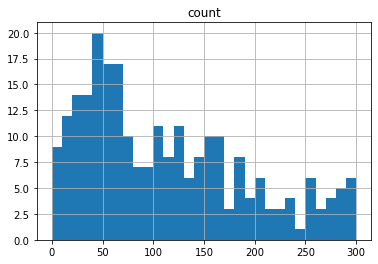

In [48]:
import pandas as pd

data = pd.read_csv('../datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index='id', values='too_fast')
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(
    index='name', values='time_spent', aggfunc='median'
)
stat['good_time_spent'] = good_stat['time_spent']

id_name = good_data.pivot_table(
    index='id', values='name', aggfunc=['first', 'count']
)
id_name.columns = ['name', 'count']

station_stat_full = id_name.join(good_stations_stat)

# две гистограммы значений 'count' из station_stat_full
station_stat_full.hist('count', bins=30)
# указан диапазон
station_stat_full.hist('count', bins=30, range=(0,300))

На первой гистограмме пик около 0 заездов, на второй - около 50. Можно чуть отступить за пик и отбросить все подозрительно непопулярные станции, куда заезжали менее 75 раз. С ними явно что-то не то. Однако таких довольно много, как бы не пришлось проводить еще одно исследование. А времени нет, и поручить некому!

Установите порог в 30.

### Задача 3/4
Выберите из `station_stat_full` АЗС с количеством заездов более 30. По этим данным найдите для каждой сети медиану продолжительности заправки и число АЗС. Результат сохраните в `good_stat2`.

Дайте столбцам с медианой и количеством станций имена `'median_time'` и `'stations'`. Распечатайте первые 5 строк `good_stat2`.
>Методом `query()` получите выборку из АЗС с количеством заездов (count) больше 30. Примените `pivot_table()` к столбцу `'name'` по значениям `'time_spent'`, чтобы найти медианное время и число АЗС для каждой сети.

>Названия столбцов вспомните, распечатав `station_stat_full`. Параметру `aggfunc` передайте список из методов `'median'` и `'count'`.

>Для переименования столбцов присвойте список из имён атрибуту `columns`.

In [49]:
# названия столбцов
station_stat_full.head()

,name,count,time_spent
id,,,
00ca1b70,Вероника,131,166.0
0178ce70,Василек,164,234.5
01abf4e9,Гацания,30,181.5
030a9067,Колокольчик,228,135.5
03740f2d,Василек,157,289.0


In [50]:
import pandas as pd

data = pd.read_csv('../datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index='id', values='too_fast')
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(
    index='id', values='time_spent', aggfunc='median'
)

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(
    index='name', values='time_spent', aggfunc='median'
)
stat['good_time_spent'] = good_stat['time_spent']

id_name = good_data.pivot_table(
    index='id', values='name', aggfunc=['first', 'count']
)
id_name.columns = ['name', 'count']
station_stat_full = id_name.join(good_stations_stat)


# получим выборку из АЗС с count больше 30
good_stat2 = (
   station_stat_full
   .query('count > 30')
   .pivot_table(index='name', values='time_spent', aggfunc=['median', 'count']) # медиана продолжительности заправки и число АЗС
)
# переименование столбцов
good_stat2.columns = ['median_time', 'stations']
print(good_stat2.head())

          median_time  stations
name                           
Агератум       308.50         3
Амарант        169.00         5
Аммобиум       178.75         4
Арктотис       190.50         3
Астильба       435.50         4


Говорят, что единственный человек, с кем нужно себя сравнивать - это вы в прошлом. Чем таблицы с информацией про АЗС хуже?  В следующей задаче узнаем, как изменилась `good_stat2` по сравнению с таблицей `stat` из прошлого.

### Задача 4/4
Объедините данные таблиц `stat` и `good_stat2`, чтобы получился датафрейм со столбцами: `'time_spent'`, `'good_time_spent'`, `'median_time'`, `'stations'`. Результат сохраните в датафрейме `final_stat`. 
`
Распечатайте его целиком и просмотрите значения в столбцах `'good_time_spent'` и `'median_time'`.
>Соедините две таблицы методом `join()`. Без каких-либо дополнительных параметров.

In [51]:
import pandas as pd

data = pd.read_csv("../datasets/visits.csv", sep="\t")
data['local_time'] = (
    pd.to_datetime(data['date_time'], yearfirst=True)
    + pd.Timedelta(hours=3)
)
data['date_hour'] = data['local_time'].dt.round('1H')
data['too_fast'] = data['time_spent'] < 60
data['too_slow'] = data['time_spent'] > 1000

too_fast_stat = data.pivot_table(index="id", values="too_fast")
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(index='id', values='time_spent', aggfunc='median')

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(index='name', values='time_spent', aggfunc='median')
stat['good_time_spent'] = good_stat['time_spent']

id_name = good_data.pivot_table(index='id', values='name', aggfunc=['first', 'count'])
id_name.columns = ['name', 'count']
station_stat_full = id_name.join(good_stations_stat)

good_stat2 = (
    station_stat_full
    .query('count > 30')
    .pivot_table(index='name', values='time_spent', aggfunc=['median', 'count'])
)
good_stat2.columns = ['median_time', 'stations']

# объединим данные таблиц stat и good_stat2
final_stat = stat.join(good_stat2)
final_stat

,time_spent,good_time_spent,median_time,stations
name,,,,
Агератум,337.802721,309.0,308.50,3.0
Амарант,132.760012,187.5,169.00,5.0
Аммобиум,256.708042,180.5,178.75,4.0
Арктотис,73.879984,185.0,190.50,3.0
Астильба,376.143149,423.0,435.50,4.0
Бальзамин,134.508411,158.0,158.00,1.0
Бархатцы,145.300328,181.5,181.50,1.0
Бегония,163.200647,195.0,190.00,3.0
Белоцветник,100.818966,154.0,154.00,1.0


Среднее время заправки в сети "Роза" теперь оцениваем как 350 секунд, а не 315. Пропали данные по сети "Обриета" - значит там были АЗС со слишком малым числом заездов.

Как убедиться, что преобразованный набор данных лучше исходного? На **графиках совместного распределения**.

<a name="9">_</a>
## Заключение

Отлично! Вы сделали это — составили рейтинг АЗС по времени заправки. Да, его можно улучшить, чем и займёмся в следующих уроках, а пока подведём итоги.

**Вы умеете:**

- фильтровать данные, применяя `query()`;
- соединять два датафрейма методом `merge()`;
- строить срезы с более сложными структурами: `Series`, словарями и датафреймами;
- объединять несколько таблиц методом `join()`: их набор передают списком вместо второго датафрейма.

Чтобы найти взаимосвязи между разными значениями, перейдём к графикам совместного распределения.

Где ещё почитать про объединение данных: <a href="https://smysl.io/blog/pandas/">Объединение датафреймов</a>.